In [1]:
import csv
import numpy as np

In [2]:
labels = []
with open('ERNData/Training/TrainLabels.csv', 'r') as f:
    reader = csv.reader(f)
    i = 0
    for row in reader:
        if(i>0):
            labels.append(row)
        i = i + 1

In [ ]:
labels = np.array(labels[:,1])
labels = labels.reshape(labels.shape[0],1)

In [10]:
l = [2,6,7,11,12,13,14,16,17,18,20,21,22,23,24,26]
l2 = [1,2,3,4,5]
filenames = []
for i in l:
    for j in l2:
        if i>9:
            if(i == 22 and j == 5):
                print("Skipped error file " + "ERNData/Training/Data_S"+ str(i)+"_Sess0"+str(j)+".csv" )
            else:
                filenames.append("ERNData/Training/Data_S"+ str(i)+"_Sess0"+str(j)+".csv")
        else:
            filenames.append("ERNData/Training/Data_S0"+ str(i)+"_Sess0"+str(j)+".csv")

Skipped error file ERNData/Training/Data_S22_Sess05.csv


In [12]:
fb1 = []
samples = []
aa = 0
for filename in filenames:
    #print(aa)
    aa += 1
    lis = []
    with open(filename,'r') as f:
        reader = csv.reader(f)
        i = 0
        for row in reader:
            if (i>0):
                lis.append(row)
            i = i + 1

    a = np.array(lis)
    b = a.astype(np.float)
    #type(b[9599][58])

    c = 0
    for i in range(1,b.shape[0]):
        if int(b[i][58]) == 1:
            samples.append(b[i:i+780,1:59])
            c += 1
            #print(np.array(samples).shape)
            #print(i," ",i/200)
            fb1.append(i)

In [25]:
s = np.array(samples)
scopy = s

In [67]:
for i in range(65,80):
    lis = []
    #print(i)
    with open(filenames[i],'r') as f:
        reader = csv.reader(f)
        i = 0
        for row in reader:
            if (i>0):
                lis.append(row)
            i = i + 1


    a = np.array(lis)
    b = a.astype(np.float)

    #type(b[9599][58])

    c = 0
    for i in range(1,b.shape[0]):
        if int(b[i][58]) == 1:
            samples.append(b[i:i+260,1:59])
            c += 1
            #print(np.array(samples).shape)
            #print(i," ",i/200)
            fb1.append(i)

    #s.shape
    

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [75]:
samples = np.array(samples)
samples_copy = samples

In [76]:
train_samples = samples[:4000,:,:]
val_samples = samples[4000:,:,:]
train_labels = labels[:4000,:]
val_labels = labels[4000:,:]

#print("train_samples.shape",train_samples.shape)

#print("train_labels.shape",train_labels.shape)

#print("val_samples.shape",val_samples.shape)

#print("val_labels.shape",val_labels.shape)

In [73]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import scipy

import scipy.io
import matplotlib.pyplot as plt
import random

In [87]:
#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(train_samples,[train_samples.shape[0],1,train_samples.shape[1],train_samples.shape[2]]).astype('float32')
y_train = np.reshape(train_labels,[train_labels.shape[0],1]).astype('float32')

X_val = np.reshape(val_samples,[val_samples.shape[0],1,val_samples.shape[1],val_samples.shape[2]]).astype('float32') 
y_val = np.reshape(val_labels,[val_labels.shape[0],1]).astype('float32')


print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


(4000, 1, 260, 58)
-------------
(4000, 1)
------------------------------
(1340, 1, 260, 58)
-------------
(1340, 1)


In [109]:
X_train = X_train[:,:,:,:56]
X_val = X_val[:,:,:,:56]

In [111]:
print(X_train.shape)
print(X_val.shape)

(4000, 1, 260, 56)
(1340, 1, 260, 56)


In [117]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1,56), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        #4, 2, 487
        self.fc1 = nn.Linear(4*2*16, 1)
        

    def forward(self, x):
        # Layer 1
      #  x = x.double()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        print (x.size())
        # FC Layer
        x = x.view(-1, 4*2*16)
        x = F.sigmoid(self.fc1(x))
        return x


net = EEGNet()#.cuda(0)
#print (net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)))))#.cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [118]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 2
    
    predicted = []
   
    inputs = Variable(torch.from_numpy(X))#.cuda(0))
    predicted = model(inputs)

    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [119]:
def train(epoch):
        running_loss=0.0
        # Mini batch training
        for i in range(0,len(X_train),batch_size):       
            #print ('Epocj,mini-batch',epoch,i)
            inputs = torch.from_numpy(X_train[i:i+batch_size])
            labels = torch.FloatTensor(y_train[i:i+batch_size]*1.0)

           # print (labels.size())
            # wrap them in Variable
            #inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print ('op',outputs.size())
            #print('labels',labels.size())
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.data[0]
             # for graphing puposes
            running_loss_array.append(loss.data[0])
        
        return running_loss_array


In [120]:
def valid(net,epoch):
    
    predicted_loss=[]
   
    inputs = torch.from_numpy(X_val)
    labels = torch.FloatTensor(y_val*1.0)

    inputs, labels = Variable(inputs), Variable(labels)

    '''
    output = net(data)
    valid_loss = valid_loss + F.nll_loss(output, target, size_average=False).data[0] 
    pred = output.data.max(1, keepdim=True)[1]
    correct = correct + pred.eq(target.data.view_as(pred)).cpu().sum() 
    '''
    ########################        
    results = []
   
    predicted = []
   
    inputs = Variable(torch.from_numpy(X_val))#.cuda(0))
    predicted = net(inputs)

    predicted = predicted.data.cpu().numpy()
    #from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
   # print ('predicted',predicted.shape)
    Y=labels.data.numpy()
    
    for param in ["acc", "auc", "recall", "precision","fmeasure"]:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
     
   # print (len(results))
    return results #validation_loss_array


Epoch  0
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
to

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([1340, 4, 2, 16])
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.6940298507462687, 0.5543273013375295, 1.0, 0.6940298507462687, 0.8193832599118943]

Epoch  6
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([1340, 4, 2, 16])
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.6940298507462687, 0.5683241542092841, 1.0, 0.6940298507462687, 0.8193832599118943]

Epoch  7
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([1340, 4, 2, 16])
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.6925373134328359, 0.5353383162863886, 0.9978494623655914, 0.6935724962630793, 0.818342151675485]

Epoch  8
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
to

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([2, 4, 2, 16])
torch.Size([

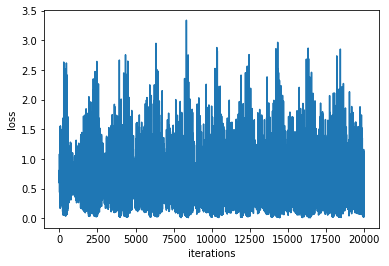

In [121]:
batch_size = 2
running_loss_array=[]

for epoch in range(10):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch)
    valid_results=valid(net,epoch)
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    # Validation accuracy
    #print ("Running Training Loss ", running_loss)
   # print ("Train - ", evaluate(net, X_train, y_train, params))
   # print ("Validation - ", evaluate(net, X_val, y_val, params))
    #print ("Test - ", evaluate(net, X_test, y_test, params))

#plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()